# visualize severity of predictions in histogram

In [1]:
import os
import sys
import pickle
import itertools
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchvision import datasets

sys.path.append('../')
from utils.directory import load_config

## input methods and set dataset to eval

In [2]:
methods = [
    'CLIP (ViT-L/14@336px)', 
    'ViT-B/16', 'ViT-B/32',
    'ViT-L/16', 'ViT-L/32',
]

dataset = 'imagenet'
partition = 'test'

## datasets 

In [3]:
config_path = '../data_paths.yml'
dataset_dir = load_config(config_path)[dataset]
dataset_dir = os.path.join(dataset_dir, partition)
eval_dataset = datasets.ImageFolder(
    root=dataset_dir, 
    transform=None,
)


def get_name(name_tag):
    return name_tag.replace('_', ' ').lower().split('@')[0]

def name_preprocessing(classnames):
    classnames = [get_name(name) for name in classnames]
    return  classnames


classnames = eval_dataset.class_to_idx
classnames = name_preprocessing(classnames)

## hierarchical distance

In [4]:
class DistanceDict(dict):
    """
    Small helper class implementing a symmetrical dictionary to hold distance data.
    """

    def __init__(self, distances):
        self.distances = {tuple(sorted(t)): v for t, v in distances.items()}

    def __getitem__(self, i):
        if i[0] == i[1]:
            return 0
        else:
            return self.distances[(i[0], i[1]) if i[0] < i[1] else (i[1], i[0])]

    def __setitem__(self, i):
        raise NotImplementedError()


def load_hie_distance(dataset, data_dir):
    if dataset == 'imagenet':
        fname = os.path.join(data_dir, dataset, 'imagenet_hdist_cupl_vcd.pkl')
    else:
        raise ValueError(f"Unknown dataset {dataset}")
    
    with open(fname, 'rb') as f:
        return DistanceDict(pickle.load(f))


data_dir = '../trees'
hdist = load_hie_distance(dataset, data_dir)

## loading prediction results

In [5]:
def load_prediction_results(method, dataset, partition):
    prompt = None
    inference = 'flat'
    if 'CLIP' in method:
        prompt = 'clip'
        fname = f'{inference}-inf-{prompt}-prompt.pkl'
    elif method == 'ViT-B/16':
        fname = 'imagenet_pretrained_ViT_B_16.pkl'
    elif method == 'ViT-B/32':
        fname = 'imagenet_pretrained_ViT_B_32.pkl'
    elif method == 'ViT-L/16':
        fname = 'imagenet_pretrained_ViT_L_16.pkl'
    elif method == 'ViT-L/32':
        fname = 'imagenet_pretrained_ViT_L_32.pkl'
    else:
        raise NotImplementedError(f'method: {method} not implemented')

    
    pred_res_path = os.path.join(f'../results-{partition}/{dataset}', fname)
        
    with open(pred_res_path, 'rb') as f:
        pred_res = pickle.load(f)
    print(f'loading inference results at {pred_res_path}')
    gt = pred_res['gt']
    pred = pred_res['pred_crm'] if method == 'CRM' else pred_res['pred']
    return gt, pred

## evaluation - utils

In [6]:
def evaluation(classnames, hdist, gt, pred):
    
    N_samples = len(gt)

    # overall top1 accuracy
    acc = np.sum(pred==gt) / N_samples

    # overall hierarchical distance @ 1
    pred_hdist = np.zeros([N_samples,])
    
    for i in tqdm(range(N_samples), total=N_samples):
        class_id_gt = gt[i]
        class_id_pred = pred[i]

        pred_hdist[i] = hdist[(classnames[class_id_gt], classnames[class_id_pred])]

    avg_hdist = np.mean(pred_hdist)
    mistake_id = np.where(pred_hdist!=0)[0]
    norm_mistake = len(mistake_id)
    avg_severity = np.sum(pred_hdist[mistake_id]) / norm_mistake
    
    print('--------------------------------')
    print(f'Top-1: {acc*100:.2f}%')
    print(f'Severity: {avg_severity: .2f}')
    print(f'HieDist@1: {avg_hdist: .2f}')
    print('--------------------------------')
    return pred_hdist[mistake_id]

## evaluation of different methods -> generate collection of prediction severities

In [7]:
severity_dict = dict()

for method in methods:
    gt, pred = load_prediction_results(method, dataset, partition)
    print(f'eval "{method}" on {partition} set of {dataset}:')
    sevs = evaluation(classnames, hdist, gt, pred)
    severity_dict[method] = sevs

loading inference results at ../results-test/imagenet/flat-inf-clip-prompt.pkl
eval "CLIP (ViT-L/14@336px)" on test set of imagenet:


100%|███████████████████████████████████████████████████████████████| 24950/24950 [00:00<00:00, 2127897.78it/s]


--------------------------------
Top-1: 76.58%
Severity:  5.46
HieDist@1:  1.28
--------------------------------
loading inference results at ../results-test/imagenet/imagenet_pretrained_ViT_B_16.pkl
eval "ViT-B/16" on test set of imagenet:


100%|███████████████████████████████████████████████████████████████| 24950/24950 [00:00<00:00, 2292044.70it/s]


--------------------------------
Top-1: 80.83%
Severity:  6.00
HieDist@1:  1.15
--------------------------------
loading inference results at ../results-test/imagenet/imagenet_pretrained_ViT_B_32.pkl
eval "ViT-B/32" on test set of imagenet:


100%|███████████████████████████████████████████████████████████████| 24950/24950 [00:00<00:00, 2264517.55it/s]


--------------------------------
Top-1: 75.68%
Severity:  6.21
HieDist@1:  1.51
--------------------------------
loading inference results at ../results-test/imagenet/imagenet_pretrained_ViT_L_16.pkl
eval "ViT-L/16" on test set of imagenet:


100%|███████████████████████████████████████████████████████████████| 24950/24950 [00:00<00:00, 2332870.05it/s]


--------------------------------
Top-1: 79.27%
Severity:  6.10
HieDist@1:  1.27
--------------------------------
loading inference results at ../results-test/imagenet/imagenet_pretrained_ViT_L_32.pkl
eval "ViT-L/32" on test set of imagenet:


100%|███████████████████████████████████████████████████████████████| 24950/24950 [00:00<00:00, 2280655.66it/s]

--------------------------------
Top-1: 76.88%
Severity:  6.20
HieDist@1:  1.43
--------------------------------


## plot histogram util
- all bins are [,) except for the right most bin: [,]

In [8]:
def histogram_plots(methods, severity_dict, hdist, classnames, dataset):
    hdist_max = -1
    for a, b in itertools.combinations(classnames, 2):
        hd = hdist[(a,b)]
        hdist_max = max(hdist_max, hd)
    print(f'{dataset}, max hdist is {hdist_max}')

    bins = [x for x in range(1, hdist_max + 2)] # need right most bin edge
    colors = ['blue', 'sandybrown', 'gold', 'orange',  'orangered']
    colors = colors[:len(methods)]
    
    fig = plt.figure(figsize=(15,5))
    plt.hist([h for _, h in severity_dict.items()], 
             bins=bins, align='left',label=methods, 
             alpha=0.6, color=colors, density=True)
    plt.xticks(bins[:-1], bins[:-1])
    plt.xlabel('mistake severity', fontsize=15)
    plt.ylabel('% of misclassifications', fontsize=15)
    plt.legend(loc='upper right', fontsize=12)
    return fig

imagenet, max hdist is 13


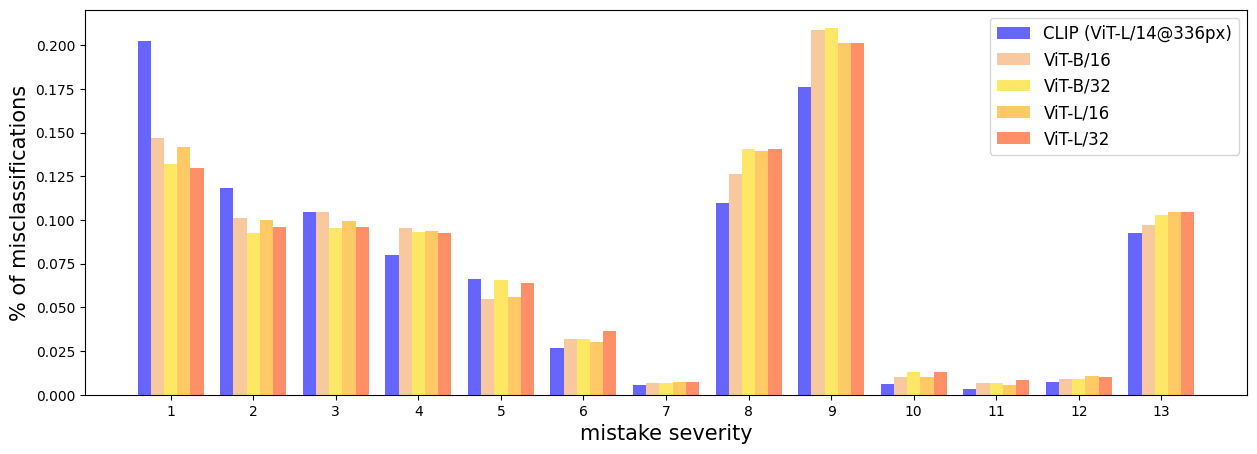

In [9]:
fig = histogram_plots(methods, severity_dict, hdist, classnames, dataset)

In [10]:
save_dir = '../assets'
if not os.path.exists(save_dir): os.makedirs(save_dir)
fig.savefig(f'{save_dir}/CLIP-vs-ViT.png')